In [1]:
%load_ext autoreload
%autoreload 2

### Baseline LLM text-classification with Langchain

**test à faire**
- model :
    - pipeline_kwargs
        - temperature, do_sample
        - max_new_tokens
    - benchmark differents modeles
- dataset : truncated quotes vs not
- prompt : engineering

- ajouter efficiency metrics : time and emissions

In [2]:
from frugalai.utils.efficiency_tracker import FunctionTimer

timer = FunctionTimer()

##### **Load dataset**

In [3]:
%%time
from datasets import load_dataset

@timer.track
def load_dataset_train():
    ds = load_dataset("QuotaClimat/frugalaichallenge-text-train")
    ds = ds.select_columns(['quote', 'label'])
    ds = ds['train']
    return ds

ds = load_dataset_train()
print(type(ds))
print(ds.shape)
print()


⏳ FunctionTimer : load_dataset_train executed in 3.8537 seconds

<class 'datasets.arrow_dataset.Dataset'>
(4872, 2)

CPU times: user 1.67 s, sys: 792 ms, total: 2.46 s
Wall time: 11 s


##### **Sample a balanced subset**

In [4]:
from frugalai.utils.analytics import print_distribution

print_distribution(ds)


🔹 Label distribution (dataset.Dataset):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          1311      26.91%
1_not_happening                         587       12.05%
2_not_human                             565       11.6%
3_not_bad                               289       5.93%
4_solutions_harmful_unnecessary         614       12.6%
5_science_unreliable                    641       13.16%
6_proponents_biased                     643       13.2%
7_fossil_fuels_needed                   222       4.56%


In [5]:
from frugalai.utils.sampling import sample_balanced_subset

subset_ds = sample_balanced_subset(ds)

print(subset_ds)
print_distribution(subset_ds)

Dataset({
    features: ['quote', 'label'],
    num_rows: 48
})

🔹 Label distribution (dataset.Dataset):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          6         12.5%
1_not_happening                         6         12.5%
2_not_human                             6         12.5%
3_not_bad                               6         12.5%
4_solutions_harmful_unnecessary         6         12.5%
5_science_unreliable                    6         12.5%
6_proponents_biased                     6         12.5%
7_fossil_fuels_needed                   6         12.5%


##### **Limit quote size**

In [6]:
threshold = 750

# Add a truncated quote column
def add_truncated_quote(example):
    example["trunc_quote"] = example["quote"][:threshold]
    return example

subset_ds = subset_ds.map(add_truncated_quote)
subset_ds

Dataset({
    features: ['quote', 'label', 'trunc_quote'],
    num_rows: 48
})

In [7]:
X_test = subset_ds["quote"]
y_test = subset_ds["label"]
len(X_test), len(y_test)

(48, 48)

##### **Load model**

In [8]:
# Select Model
MODEL_NAMES = {
    "mistral": "mistralai/Mistral-7B-Instruct-v0.1",
    "phi3": "microsoft/Phi-3-mini-4k-instruct",
    "qwen": "Qwen/Qwen2.5-0.5B"
}
selected_model = "phi3"
model_name = MODEL_NAMES[selected_model]
model_name

'microsoft/Phi-3-mini-4k-instruct'

In [9]:
%%time

from langchain_huggingface import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
import torch

pipeline_kwargs={
    "max_new_tokens": 20, #1
    "top_k": 50,
    #"device_map":"auto",
    #"batch_size": 8,  # Process 8 quotes at a time
    #repetition_penalty=1.03,
}

# deterministic (do_sample = False, temperature = 0)
@timer.track
def load_model(model_name):
    torch.mps.empty_cache()
    llm = HuggingFacePipeline.from_model_id(
        model_id=model_name,
        task="text-generation",
        pipeline_kwargs=pipeline_kwargs,
    )
    llm_engine = ChatHuggingFace(llm=llm)
    return llm_engine

model = load_model(model_name)
print(type(model))
print()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use mps:0



⏳ FunctionTimer : load_model executed in 89.0175 seconds

<class 'langchain_huggingface.chat_models.huggingface.ChatHuggingFace'>

CPU times: user 11 s, sys: 12.4 s, total: 23.4 s
Wall time: 1min 35s


In [10]:
from frugalai.utils.monitoring import model_cache_state

model_cache_state()

📁 Hugging Face Model Cache: /Users/a.villa.massone/.cache/huggingface/hub

📌 28.97 GB	| models--mistralai--Mistral-7B-Instruct-v0.1
📌 15.29 GB	| models--microsoft--Phi-3-mini-4k-instruct
📌 3.26 GB	| models--facebook--bart-large-mnli
📌 0.02 GB	| models--Qwen--Qwen2.5-0.5B
📌 30.49 GB	| models--Qwen--Qwen2.5-7B
📌 7.12 GB	| models--deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B

🛑 Total Cache Size: 85.16 GB


In [11]:
from frugalai.utils.monitoring import model_memory_need

model_memory_need(model=model)

{'model_name': 'microsoft/Phi-3-mini-4k-instruct',
 'model_type': transformers.models.phi3.modeling_phi3.Phi3ForCausalLM,
 'total_params_Billion': 3.82,
 'precision': torch.float32,
 'estimated_memory_gb': 15.28}

In [12]:
from frugalai.utils.monitoring import pytorch_print_cache

pytorch_print_cache()

Allocated by MPS: 15.28 GB
Allocated by driver: 16.11 GB
Available system memory: 4.43 GB


##### **Tests**

In [13]:
%%time
# Test with basic message
response = model.invoke("Hugging Face is")
print("\noutput type :\n", type(response))
print("\nfull output :\n", response)
print("\ncontent :\n", response.content)
print()


output type :
 <class 'langchain_core.messages.ai.AIMessage'>

full output :
 content='<|user|>\nHugging Face is<|end|>\n<|assistant|>\n Hugging Face is a company that provides AI models and tools for natural language processing (N' additional_kwargs={} response_metadata={} id='run-3659600f-821b-40fc-91a6-d89041de75cd-0'

content :
 <|user|>
Hugging Face is<|end|>
<|assistant|>
 Hugging Face is a company that provides AI models and tools for natural language processing (N

CPU times: user 1.37 s, sys: 5.65 s, total: 7.02 s
Wall time: 28.2 s


In [14]:
%%time
# Test with structured messages and system message
from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
)

messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(
        content="Hugging Face is"
    ),
]

ai_msg = model.invoke(messages)
print("\noutput type :\n", type(ai_msg))
print("\nfull output :\n", ai_msg)
print("\ncontent :\n", ai_msg.content)
print()


output type :
 <class 'langchain_core.messages.ai.AIMessage'>

full output :
 content="<|system|>\nYou're a helpful assistant<|end|>\n<|user|>\nHugging Face is<|end|>\n<|assistant|>\n Hugging Face is a company that provides AI models and tools for natural language processing (N" additional_kwargs={} response_metadata={} id='run-d9636c1c-e33b-4925-a9b6-82ec76b0a1ff-0'

content :
 <|system|>
You're a helpful assistant<|end|>
<|user|>
Hugging Face is<|end|>
<|assistant|>
 Hugging Face is a company that provides AI models and tools for natural language processing (N

CPU times: user 1.08 s, sys: 119 ms, total: 1.2 s
Wall time: 3.73 s


In [15]:
%%time
# Test with chained Output parser
from langchain_core.output_parsers import StrOutputParser

chain = (
    model
    | StrOutputParser()
)
output = chain.invoke("Hugging Face is")
print("\noutput type :\n", type(output))
print("\nfull output :\n", output)
print()


output type :
 <class 'str'>

full output :
 <|user|>
Hugging Face is<|end|>
<|assistant|>
 Hugging Face is a company that provides AI models and tools for natural language processing (N

CPU times: user 1.05 s, sys: 114 ms, total: 1.16 s
Wall time: 3.61 s


##### **Prompt template**

In [16]:
# PromptTemplate
from langchain_core.prompts import PromptTemplate

# Define the classification prompt
prompt_template = f"""
<instruction>
Classify the following statement into one of these 8 categories:
Respond STRICTLY with only the corresponding number. 
DO NOT INCLUDE ANY OTHER TEXT.
If you do not know the answer, make your best guess.
</instruction>

<categories>
0 - Not relevant: No climate-related claims or doesn't fit other categories
1 - Denial: Claims climate change is not happening
2 - Attribution denial: Claims human activity is not causing climate change
3 - Impact minimization: Claims climate change impacts are minimal or beneficial
4 - Solution opposition: Claims solutions to climate change are harmful
5 - Science skepticism: Challenges climate science validity or methods
6 - Actor criticism: Attacks credibility of climate scientists or activists
7 - Fossil fuel promotion: Asserts importance of fossil fuels
</categories>

<statement>
Statement: "{{quote}}"
</statement>

Category number:"""

# Create the prompt template
prompt = PromptTemplate(template=prompt_template, input_variables=["quote"])

##### **Output parser**

In [17]:
# StrOutputParser
from langchain_core.output_parsers import StrOutputParser

# Class Labels
CLASS_LABELS = [
    "0_not_relevant", "1_not_happening", "2_not_human", "3_not_bad",
    "4_solutions_harmful_unnecessary", "5_science_unreliable",
    "6_proponents_biased", "7_fossil_fuels_needed"
]

# Define an output parser for cleaning up the response
class CustomOutputParser(StrOutputParser):
    def parse(self, text: str) -> int:
        parts = text.split('<|assistant|>')
        if len(parts) > 1:
            response = parts[1].strip()
            if response.isdigit() and int(response) in range(8):  
                return CLASS_LABELS[int(response)]
            if response == "?":
                return "unknown"
        return '-1'

    
# Create the output parser
output_parser = CustomOutputParser()

##### **Chain**

In [18]:
# Chain
chain = prompt | model | output_parser
type(chain)

langchain_core.runnables.base.RunnableSequence

##### **tests on chain**

In [19]:
%%time
# Example statement
statement = "Climate change is just a hoax created to control people."
output = chain.invoke({"quote": statement})

print("\nstatement :\n", statement)
print("\noutput type :", type(output))
print("\ncategory :", output)
print()


statement :
 Climate change is just a hoax created to control people.

output type : <class 'str'>

category : 1_not_happening

CPU times: user 279 ms, sys: 337 ms, total: 616 ms
Wall time: 1.59 s


In [20]:
%%time
# test for one quote
for x, y in zip(X_test, y_test):
    quote = x
    label = y
    break
print("quote :\n", quote)
print("label :", label)

response = chain.invoke({"quote": quote})
print("\nprediction :", response)
print()

quote :
 State attorneys general are supposed to enforce the law and serve the public interest, but instead these Republican officials have hung a ‘For Sale’ sale on their door, and the fossil fuel industry proved to be the highest bidder,” said Surgey. “It’s no coincidence that GOP attorneys general have mounted an aggressive fight alongside the fossil fuel industry to block the Clean Power Plan – that appears to be exactly what the industry paid for. Together, these documents reveal a sustained pattern of collusion between the fossil fuel industry and the Republican attorneys general on climate change obstructionism.
label : 0_not_relevant

prediction : 7_fossil_fuels_needed

CPU times: user 241 ms, sys: 527 ms, total: 768 ms
Wall time: 1.85 s


##### **Batch inference**

In [21]:
%%time
from tqdm import tqdm

@timer.track
def inference(quotes):
    y_pred = []
    for quote in tqdm(quotes, desc="Inference on X_test"):
        y_pred.append(chain.invoke({"quote": quote}))
    print()
    return y_pred

y_pred = inference(X_test)

Inference on X_test: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:45<00:00,  2.19s/it]



⏳ FunctionTimer : inference executed in 105.0943 seconds

CPU times: user 13.2 s, sys: 29.2 s, total: 42.5 s
Wall time: 1min 45s


In [22]:
# batch prend bcp trop de temps
#%%time
#import pandas as pd

#batch_X_test = pd.Series(X_test).apply(lambda quote : {"quote": quote})
#print('batch_X_test', type(batch_X_test), len(batch_X_test))
#batch_X_test[:5]
#y_pred = chain.batch(batch_X_test.tolist())

#y_pred_s = pd.Series(y_pred)
#y_pred_s

##### **Evaluation**

In [23]:
from frugalai.utils.evaluation import create_results_df

results_df = create_results_df(X_test, y_test, y_pred)
results_df.head()

,X_test,y_test,y_pred,correct
0,State attorneys general are supposed to enforc...,0_not_relevant,7_fossil_fuels_needed,False
1,ExxonMobil is currently the worst of the oil g...,0_not_relevant,7_fossil_fuels_needed,False
2,"Call it the new Great New Reset, New World Ord...",0_not_relevant,0_not_relevant,True
3,Cool Clouded Fact: The idea of climate change ...,0_not_relevant,1_not_happening,False
4,Oil money has also contributed to the network ...,0_not_relevant,7_fossil_fuels_needed,False


In [24]:
from frugalai.utils.evaluation import performance_breakdown

performance = performance_breakdown(results_df)
performance

,Outcome,Count
0,Correct,25
1,Incorrect,23
2,Unknown,0
3,Error,0


In [25]:
print_distribution(y_test)
print_distribution(y_pred)


🔹 Label distribution (list):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          6         12.5%
1_not_happening                         6         12.5%
2_not_human                             6         12.5%
3_not_bad                               6         12.5%
4_solutions_harmful_unnecessary         6         12.5%
5_science_unreliable                    6         12.5%
6_proponents_biased                     6         12.5%
7_fossil_fuels_needed                   6         12.5%

🔹 Label distribution (list):
Category                                Count     Percentage
------------------------------------------------------------
0_not_relevant                          2         4.17%
1_not_happening                         7         14.58%
2_not_human                             2         4.17%
3_not_bad                               6         12.5%
4_solutions_harmful_unn

In [26]:
from frugalai.utils.evaluation import evaluation

accuracy, metrics_df = evaluation(y_test, y_pred)

print('accuracy :', round(accuracy, 2))

accuracy : 0.52


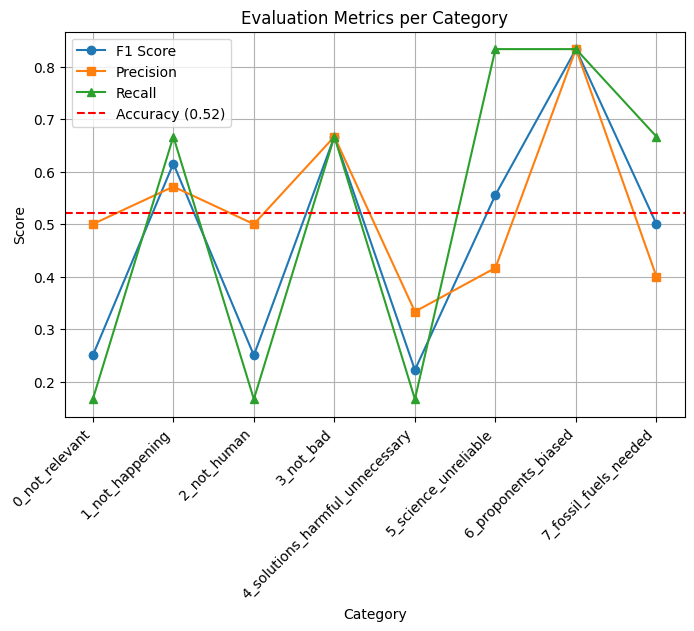

Category metrics
                          Category  Precision  Recall  F1 Score
0                   0_not_relevant       0.50    0.17      0.25
1                  1_not_happening       0.57    0.67      0.62
2                      2_not_human       0.50    0.17      0.25
3                        3_not_bad       0.67    0.67      0.67
4  4_solutions_harmful_unnecessary       0.33    0.17      0.22
5             5_science_unreliable       0.42    0.83      0.56
6              6_proponents_biased       0.83    0.83      0.83
7            7_fossil_fuels_needed       0.40    0.67      0.50



In [27]:
from frugalai.utils.evaluation import plot_metrics

plot_metrics(accuracy, metrics_df)

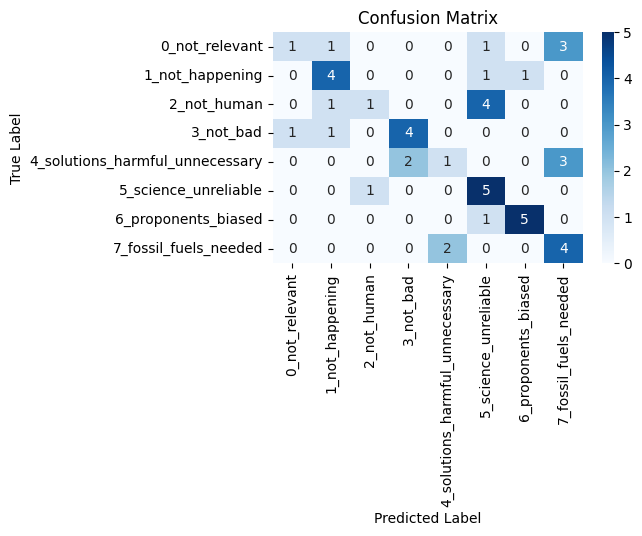

In [28]:
from frugalai.utils.evaluation import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred)

##### **Experiment recording**

In [29]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-02-19_17:06:38'

In [30]:
import json
import pprint

meta_data = {
    "model_name": model_name,
    "accuracy": round(accuracy, 2),
    "timestamp": timestamp,
    
    "model_details": model_memory_need(model=model),
    "pipeline_kwargs": pipeline_kwargs,

    "quote_len_truncated": False if (max(results_df['X_test'].apply(len)) < threshold) == False else threshold,
    
    "prompt_template": prompt_template,
    
    "performance": performance.to_dict(),
    "model_pipeline" : model
}

pprint.pprint(meta_data, width=100, sort_dicts=False) 

{'model_name': 'microsoft/Phi-3-mini-4k-instruct',
 'accuracy': 0.52,
 'timestamp': '2025-02-19_17:06:38',
 'model_details': {'model_name': 'microsoft/Phi-3-mini-4k-instruct',
                   'model_type': <class 'transformers.models.phi3.modeling_phi3.Phi3ForCausalLM'>,
                   'total_params_Billion': 3.82,
                   'precision': torch.float32,
                   'estimated_memory_gb': 15.28},
 'pipeline_kwargs': {'max_new_tokens': 20, 'top_k': 50},
 'quote_len_truncated': False,
 'prompt_template': '\n'
                    '<instruction>\n'
                    'Classify the following statement into one of these 8 categories:\n'
                    'Respond STRICTLY with only the corresponding number. \n'
                    'DO NOT INCLUDE ANY OTHER TEXT.\n'
                    'If you do not know the answer, make your best guess.\n'
                    '</instruction>\n'
                    '\n'
                    '<categories>\n'
                    "0 - Not

In [31]:
import os
import json

# Define experiment directories
experiment_dir = "experiments"
data_dir = os.path.join(experiment_dir, "data")
metrics_dir = os.path.join(experiment_dir, "metrics")

# Ensure directories exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# Define file names
filename = (
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{round(accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
)

filename_meta = os.path.join(metrics_dir, filename + ".json")
filename_data = os.path.join(data_dir, filename + ".csv")
print(filename_meta)
print(filename_data)

experiments/metrics/microsoft_Phi-3-mini-4k-instruct_accuracy_52_dt_20250219_170638.json
experiments/data/microsoft_Phi-3-mini-4k-instruct_accuracy_52_dt_20250219_170638.csv


In [32]:
# Save JSON file
with open(filename_meta, "w") as f:
    json.dump(meta_data, f, indent=4, default=str)
    print(f"✅ Metrics saved to: {filename_meta}")

✅ Metrics saved to: experiments/metrics/microsoft_Phi-3-mini-4k-instruct_accuracy_52_dt_20250219_170638.json


In [33]:
results_df.to_csv(filename_data)
print(f"✅ Data saved to {filename_data}")

✅ Data saved to experiments/data/microsoft_Phi-3-mini-4k-instruct_accuracy_52_dt_20250219_170638.csv
